# Assignment for Big Data Module 1

"*Implementare un interpolatore lineare a tratti su una griglia a $n$ dimensioni.*

*Supporre che sia data la struttura dati multidimensionale $S_{j_0, \cdots, j_{n - 1}}$ che contiene il valore del campione della funzione nel punto della griglia di indici $j_0, \cdots, j_{n-1}$ e che il punto in cui desidero calcolare l'interpolazione sia dato come un vettore $x_j$ con $n$ componenti.*"

Reference used: course lecture notes *4 - Interpolation*.

In [ ]:
import numpy as np
np.random.seed(0)
from itertools import product # Cartesian product

Implementation of the convex decomposition of $\mathbf{x} \in [0, 1]^n$ into
*   $n + 1$ selected vectors $\texttt{b[j]} = \mathbf{b}^j \in \mathbb{B}$, with $\mathbb{B} = \{0, 1\}^n$
*   as many relative coefficients $\texttt{a[j]} = {\alpha_\mathbf{b}^j} \ge 0$ s.t. ${\sum_{j = 0}^{n}} \alpha_{\mathbf{b}^j} = 1$.

In [ ]:
def my_decomposition(x):
    
    n = len(x)          # dimension
    p = x.argsort()     # permutation that sorts x in ascending order
    B = np.concatenate( # B[j] will be the j-th element of the base
        (
            np.ones((n, n), dtype=bool),
            np.zeros((1, n), dtype=bool)
        )
    )
    a = np.zeros(n + 1) # alpha coefficients
    
    # implementation of loop algorithm of Notes "4 - Interpolation", page 9.
    a[0] = x[p[0]]
    for j in range(1, n):
        B[j:, p[j - 1]] = 0 # this entry zeroed out from now on (typo in the notes)
        a[j] = x[p[j]] - x[p[j - 1]]
    a[n] = 1 - a.sum()


    # xxx FLIPS DONE IN B

    # xxx FLIPS DONE IN MORE EFFICIENT WAY:
    n1 = (n + 1) // 2 + n % 2
    n0 = (n + 1) - n1
    B = np.concatenate(
        (
            np.ones((n1, n), dtype=bool),  # 1st half (rounded up) all 1s
            np.zeros((n0, n), dtype=bool), # 2nd half (rounded down) all 0s
        ),
    )
    for i in range(1, n1):
        B[i:, p[i - 1]] = False
    for i in range(n1, -1, n + 1):
        B[n1:i, p[i]] = True





    return p, B, a

Correctness check of the implementation: $\mathbf{x} = {\sum_{j = 0}^{n}} \alpha_{\mathbf{b}^j} \mathbf{b}^j$ must hold.

In [ ]:
n = np.random.randint(1, 1 + 10, (1,)).item() # random dimension (max 5)
x = np.random.rand(n)                        # random vector in [0, 1)^n

p, B, a = my_decomposition(x)

print(B.shape, a.shape)

aB = np.dot(a, B)                            # recomposition
d = ((aB - x)**2).sum()**0.5                 # Euclidean distance

# show summary of the test
print('\nVector')
print('n = %d' % n)
print('x =', x)
print('\nDecomposition')
print('p =', p)
print('B =')
print(B.astype(np.int))
print('a =', a)
print('\nCheck of recomposition')
print('  x =', x)
print('a*B =', aB)
print('\nTheoretical discrepancy is 0. Numerical discrepancy: d =', d)

(10, 9) (10,)

Vector
n = 9
x = [0.35231166 0.46924917 0.84114013 0.90464774 0.03755938 0.50831545
 0.16684751 0.77905102 0.8649333 ]

Decomposition
p = [4 6 0 1 5 7 2 8 3]
B =
[[1 1 1 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1]
 [1 1 1 1 0 1 0 1 1]
 [0 1 1 1 0 1 0 1 1]
 [0 0 1 1 0 1 0 1 1]
 [0 0 1 1 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
a = [0.03755938 0.12928813 0.18546415 0.11693751 0.03906627 0.27073557
 0.06208911 0.02379317 0.03971445 0.09535226]

Check of recomposition
  x = [0.35231166 0.46924917 0.84114013 0.90464774 0.03755938 0.50831545
 0.16684751 0.77905102 0.8649333 ]
a*B = [0.35231166 0.46924917 0.77905102 0.77905102 0.03755938 0.50831545
 0.16684751 0.77905102 0.77905102]

Theoretical discrepancy is 0. Numerical discrepancy: d = 0.1643330768978116


Implementation of $\texttt{fhat} = \hat{f}(\cdot)$, based on the data structure $\texttt{S} = S_{j_0, \cdots, j_{n - 1}}$.

In [ ]:
def fhat(x):
    
    n = len(x)                     # dimension
    z = np.floor(x).astype(np.int) # vector integer part
    x = x - z                      # vector fractional part
    
    _, B, a = my_decomposition(x)
    
    z_plus_B = [tuple(z + B[i]) for i in range(n + 1)] # point z (broadcast) + all vectors B
                                                       # I nedd tuples to...
    
    f_zplusB = np.array([S[zplusb] for zplusb in z_plus_B])
    # S is the data structure f(z grid)
    # NB I use S, not call f
    # f(vector z + all vectors B)
    
    return np.dot(a, f_zplusB) 

In [ ]:
# My scalar function to interpolate
def f(x):
    return np.sin(x / 10).sum(-1)


J = (100,) # number of grid points in each dimension
n = len(J)       # dimension

# Grid Z subset of (Integers)^n
Z = [np.arange(J[i]) for i in range(n)]

S = np.zeros(J)
for z in product(*Z): # Cartesian product done via itertool.product
    S[z] = f(np.array(z))

# A random point where to interpolate
x_integral = np.concatenate(tuple(np.random.randint(0, J[i] - 1, (1,)) for i in range(n)))
x_fractional = np.random.rand(n)
x = x_integral + x_fractional
print(x)
#x = x_integral
print(x)

fx, fhatx = f(x), fhat(x)
e = abs(fhatx - fx)
print('   f(x) =', fx)
print('fhat(x) =', fhatx)
print('Interpolation error: e = |fhat(x) - f(x)| =', e)

[60.17295379]
[60.17295379]
   f(x) = -0.262768026865253
fhat(x) = -0.2625952238357608
Interpolation error: e = |fhat(x) - f(x)| = 0.00017280302949224113


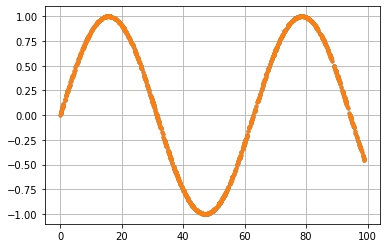

In [ ]:
M = 1000
x = []
fx = []
fhatx = []
for m in range(M):
    x_integral = np.concatenate(tuple(np.random.randint(0, J[i] - 1, (1,)) for i in range(n)))
    x_fractional = np.random.rand(n)
    x.append(x_integral + x_fractional)
    fx.append(f(x[-1]))
    fhatx.append(fhat(x[-1]))

import matplotlib.pyplot as plt
plt.plot(x, fx, '.')
plt.plot(x, fhatx, '.')
plt.grid()
plt.show()
